In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Import Packages

In [2]:
import os
import re
import nltk
import keras
nltk.download('stopwords')
import numpy as np 
np.random.seed(20)
import pandas as pd
import seaborn as sns
import tensorflow as tf
from nltk import pos_tag
from attention import Attention
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes, svm
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class DisasterTweetClassification:
    def __init__(self):
        self.load_data()
        self.exploratory_data_analysis()
        self.data_preprocessing()
        self.data_split()
        self.convert_data_into_tensorflow_format()
        self.vectorize_tweets()
    
    def load_data(self):
        print("\n Loading Data ----> ")
        self.df_train = pd.read_csv("train.csv")
        self.df_test = pd.read_csv("test.csv")
        print("Train Data Sample ----> ")
        print(self.df_train.head())
        print("Test Data Sample ----> ")
        print(self.df_test.head())
        
    def exploratory_data_analysis(self):
        print("\n Exploraory Data Analysis ----> ")
        print("Train Data Description ----> ")
        print(self.df_train.describe())
        self.find_text_length_and_frequency()
        self.generate_word_cloud()
    
    def find_text_length_and_frequency(self):
        print("\n Finding Text Length and Frequency ----> ")
        self.df_train["no_of_words_text"] = self.df_train["text"].apply(lambda text: len(text.split()))
        plt.figure(figsize=(15,10))
        sequence_length = self.df_train["no_of_words_text"].tolist()
        sns.countplot(sequence_length)
        plt.xlabel("No of Words in Text---->")
        plt.ylabel("No of Such Texts---->")
        plt.title("Plot of Text Length vs Count")
        plt.show()
        
    def generate_word_cloud(self):
        print("\n Creating Word Cloud ----> ")
        all_words = ""
        for i in range(self.df_train.shape[0]):
            all_words = all_words + self.df_train['text'].iloc[i]
        word_cloud_model = WordCloud(collocations = False, background_color = 'black').generate(all_words)
        plt.figure(figsize=(20,20))
        plt.imshow(word_cloud_model, interpolation='bilinear')
        plt.show()
    
    def data_preprocessing(self):
        print("\n Cleaning Data ----> ")
        print("Dropping Duplicates ----> ")
        print("Shape of Data Before Dropping Duplicates ----> {0}".format(self.df_train.shape[0]))
        self.df_train.drop_duplicates(['text', 'target'], keep='first', inplace=True)
        print("Shape of Data After Dropping Duplicates ----> {0}".format(self.df_train.shape[0]))
        print("Calculating Target Count ----> ")
        print(self.df_train["target"].value_counts())
        sns.countplot(self.df_train['target'])
        plt.title('Count of Non Disaster Tweets:'+str(self.df_train.target.value_counts()[0])+'\n'+
         'Count of Disaster Tweets:'+str(self.df_train.target.value_counts()[1]))
        plt.show()
        print("Cleaning Tweets ----> ")
        self.df_train["preprocessed_text"] = self.df_train["text"].apply(lambda text:self.clean_tweets(text))
    
    def clean_tweets(self,raw_text):
        emoji_patt = re.compile("["
            u"\U0001F600-\U0001F64F"  
            u"\U0001F300-\U0001F5FF"  
            u"\U0001F680-\U0001F6FF"  
            u"\U0001F1E0-\U0001F1FF"  
            u"\U0001F1F2-\U0001F1F4"  
            u"\U0001F1E6-\U0001F1FF"  
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)
        raw_text = emoji_patt.sub(r'', raw_text)
        clean_text = raw_text.lower()
        clean_text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', clean_text)
        clean_text = re.sub(r'\([^)]*\)', '', clean_text)
        clean_text = re.sub(r'\{[^)]*\}', '', clean_text)
        clean_text = re.sub("[^a-zA-Z]", " ", clean_text)
        stopwords_nltk = stopwords.words('english')
        cleaned_tokens = [words for words in clean_text.split() if not words in stopwords_nltk] 
        meaningful_tokens = [tok for tok in cleaned_tokens if len(tok)>=4] 
        final_cleaned_text = " ".join(meaningful_tokens)
        final_cleaned_text = final_cleaned_text.strip()
        return final_cleaned_text
    
    def data_split(self):
        print("\n Splitting Data into Train, Test and Validation Sample ----> ")
        self.trainD, self.testD = train_test_split(self.df_train, test_size=0.2, random_state=100, stratify=self.df_train["target"])
        self.testD, self.valD = train_test_split(self.testD, test_size=0.5, random_state=100)
        print("Training Sample ----> ", self.trainD.shape)
        print("Testing Sample ----> ", self.testD.shape)
        print("Validation Sample ----> ", self.valD.shape)
        self.X_train = self.trainD["preprocessed_text"].tolist() 
        self.y_train = self.trainD["target"].tolist()
        self.X_test = self.testD["preprocessed_text"].tolist() 
        self.y_test = self.testD["target"].tolist()
        self.X_val = self.valD["preprocessed_text"].tolist() 
        self.y_val = self.valD["target"].tolist()
    
    def convert_data_into_tensorflow_format(self):
        print("\n Converting Data into Tensorflow Format ----> ")
        BUFFER_SIZE = 8000
        BATCH_SIZE = 32
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        self.test_dataset = tf.data.Dataset.from_tensor_slices((self.X_test, self.y_test))
        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val))
        self.train_dataset = self.train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        self.test_dataset = self.test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        self.val_dataset = self.val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    def vectorize_tweets(self):
        print("\n Vectorizing Tweets ----> ")
        self.vectorizer_model = TfidfVectorizer()
        self.vectorizer_model.fit(self.df_train['preprocessed_text'])
        print("Vocabulary Length ----> ",len(self.vectorizer_model.vocabulary_))
        self.X_train_idf = self.vectorizer_model.transform(self.X_train)
        self.X_test_idf = self.vectorizer_model.transform(self.X_test)
    
    def train_naive_bayes(self):
        print("\n Training Multinomial Naive Bayes Algorithm ----> ")
        mnb_model = naive_bayes.MultinomialNB()
        mnb_model.fit(self.X_train_idf,self.y_train)
        predicted_val = mnb_model.predict(self.X_test_idf)
        print("Naive Bayes Accuracy ----> ",accuracy_score(predicted_val, self.y_test)*100)
    
    def train_support_vector_machines(self):
        print("\n Training Support Vector Machine Algorithm ----> ")
        svm_model = svm.SVC()
        svm_model.fit(self.X_train_idf,self.y_train)
        predicted_val = svm_model.predict(self.X_test_idf)
        print("SVM Accuracy ----> ",accuracy_score(predicted_val, self.y_test)*100)
    
    def plot_graphs(self,history, metric):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_'+metric])
    
    def lstm_without_embedding(self):
        print("\n Training LSTM without Embeddings ----> ")
        VOCAB_SIZE = 10000
        encoder_model = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
        encoder_model.adapt(self.train_dataset.map(lambda text, label: text))
        lstm_model = tf.keras.Sequential([encoder_model,
            tf.keras.layers.Embedding(input_dim=len(encoder_model.get_vocabulary()),output_dim=128,mask_zero=True),
            tf.keras.layers.LSTM(64, dropout=0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1)])
        lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      metrics=['accuracy'])
        history = lstm_model.fit(self.train_dataset, epochs=5,validation_data=self.val_dataset)
        test_loss, test_acc = lstm_model.evaluate(self.test_dataset)
        print('LSTM WITHOUT EMBEDDING TEST LOSS:', test_loss)
        print('LSTM WITHOUT EMBEDDING TEST ACCURACY:', test_acc)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None)
        
    def bilstm_without_embedding(self):
        print("\n Training Bidirectional LSTM without Embeddings ----> ")
        VOCAB_SIZE = 10000
        encoder_model = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
        encoder_model.adapt(self.train_dataset.map(lambda text, label: text))
        bilstm_model = tf.keras.Sequential([encoder_model,
                       tf.keras.layers.Embedding(
                       input_dim=len(encoder_model.get_vocabulary()),
                       output_dim=128,
                       mask_zero=True),
                       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2)),
                       tf.keras.layers.Dense(256, activation='relu'),
                       tf.keras.layers.Dropout(0.5),
                       tf.keras.layers.Dense(1)])
        bilstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      metrics=['accuracy'])
        history = bilstm_model.fit(self.train_dataset, epochs=5,validation_data=self.val_dataset)
        test_loss, test_acc = bilstm_model.evaluate(self.test_dataset)
        print('BIDIRECTIONAL LSTM WITHOUT EMBEDDING TEST LOSS:', test_loss)
        print('BIDIRECTIONAL LSTM WITHOUT EMBEDDING TEST ACCURACY:', test_acc)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None) 
        
    def lstm_with_attention(self):
        print("\n Training LSTM with Attention ----> ")
        VOCAB_SIZE = 10000
        encoder_model = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
        encoder_model.adapt(self.train_dataset.map(lambda text, label: text))
        lstm_attention_model = tf.keras.Sequential()
        lstm_attention_model.add(encoder_model)
        lstm_attention_model.add(tf.keras.layers.Embedding(
                input_dim=len(encoder_model.get_vocabulary()),
                output_dim=128,
                mask_zero=True))
        lstm_attention_model.add(tf.keras.layers.LSTM(64, dropout=0.2, return_sequences=True))
        lstm_attention_model.add(Attention())
        lstm_attention_model.add(tf.keras.layers.Dense(256, activation='relu'))
        lstm_attention_model.add(tf.keras.layers.Dropout(0.5))
        lstm_attention_model.add(tf.keras.layers.Dense(1))
        lstm_attention_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      metrics=['accuracy'])
        history = lstm_attention_model.fit(self.train_dataset, epochs=5,validation_data=self.val_dataset)
        test_loss, test_acc = lstm_attention_model.evaluate(self.test_dataset)
        print('LSTM WITH ATTENTION TEST LOSS:', test_loss)
        print('LSTM WITH ATTENTION TEST ACCURACY:', test_acc)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None)
        
    def lstm_with_glove(self):
        print("\n Training LSTM with Glove ----> ")
        vectorizer_model = TextVectorization(max_tokens=14000, output_sequence_length=200)
        vectorizer_model.adapt(self.train_dataset.map(lambda text, label: text))
        vocab = vectorizer_model.get_vocabulary()
        word_index_dict = dict(zip(vocab, range(len(vocab))))
        glove_file_path = "glove.6B.100d.txt"
        embeddings_index_dict = {}
        with open(glove_file_path,errors='ignore') as file:
            for data in file:
                word, coefs = data.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings_index_dict[word] = coefs
        print("Found {0} Word Embeddings".format(len(embeddings_index_dict)))
        num_tokens = 14000 + 2
        embedding_dimension = 100
        hits = 0
        misses = 0
        embedding_matrix = np.zeros((num_tokens, embedding_dimension))
        for word, i in word_index_dict.items():
            embedding_vector = embeddings_index_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        print("Converted {0} Words ({1} Misses)".format(hits, misses))
        embedding_layer = Embedding(num_tokens,
                                    embedding_dimension,
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    trainable=False,
                                    name="Embeddings")
        lstm_glove_model = tf.keras.Sequential()
        lstm_glove_model.add(vectorizer_model)
        lstm_glove_model.add(embedding_layer)
        lstm_glove_model.add(tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True))
        lstm_glove_model.add(Attention())
        lstm_glove_model.add(tf.keras.layers.Dense(128, activation='relu'))
        lstm_glove_model.add(tf.keras.layers.Dropout(0.2))
        lstm_glove_model.add(tf.keras.layers.Dense(1))
        lstm_glove_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                      metrics=['accuracy'])
        tf.keras.utils.plot_model(lstm_glove_model)
        history = lstm_glove_model.fit(self.train_dataset, epochs=9,validation_data=self.val_dataset)
        test_loss, test_acc = lstm_glove_model.evaluate(self.test_dataset)
        print('LSTM WITH GLOVE TEST LOSS:', test_loss)
        print('LSTM WITH GLOVE TEST ACCURACY:', test_acc)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        self.plot_graphs(history, 'accuracy')
        plt.ylim(None, 1)
        plt.subplot(1, 2, 2)
        self.plot_graphs(history, 'loss')
        plt.ylim(0, None)

# Create Disaster Tweet Class Object
### Load Data | EDA | Data Preprcessing | Data Split 


 Loading Data ----> 
Train Data Sample ----> 
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Test Data Sample ----> 
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN  

C:\Users\gupta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


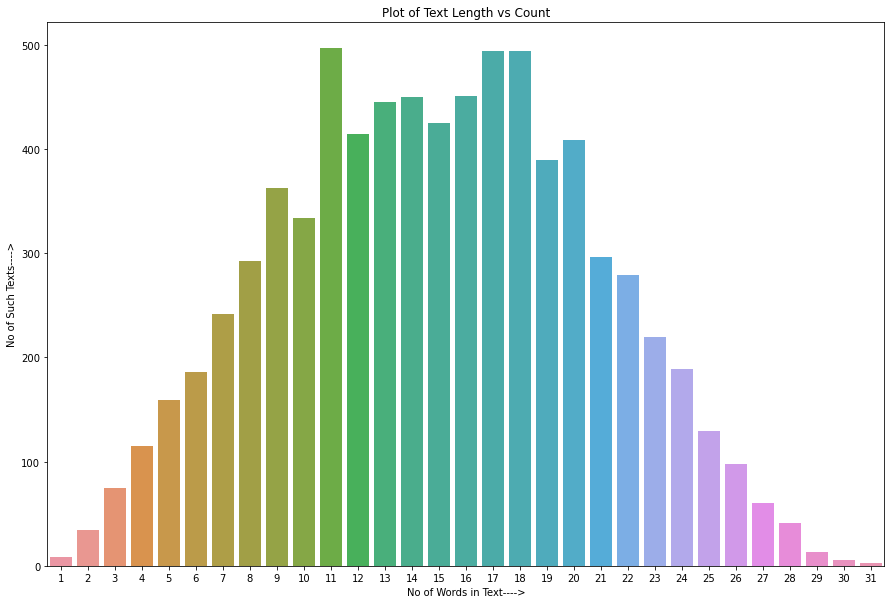


 Creating Word Cloud ----> 


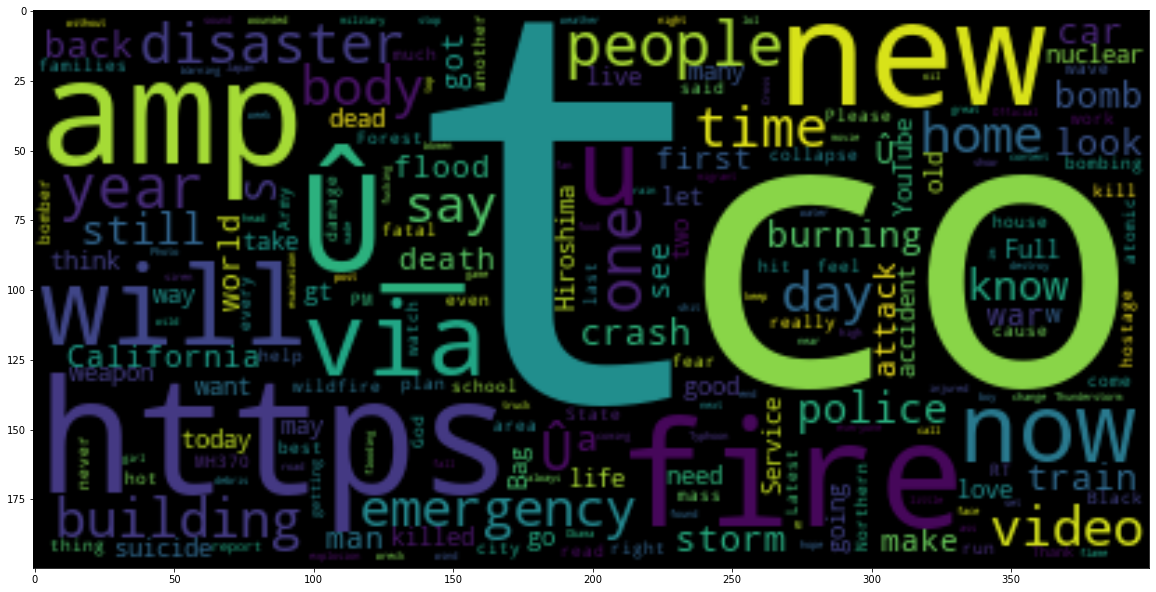


 Cleaning Data ----> 
Dropping Duplicates ----> 
Shape of Data Before Dropping Duplicates ----> 7613
Shape of Data After Dropping Duplicates ----> 7521
Calculating Target Count ----> 
0    4315
1    3206
Name: target, dtype: int64


C:\Users\gupta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


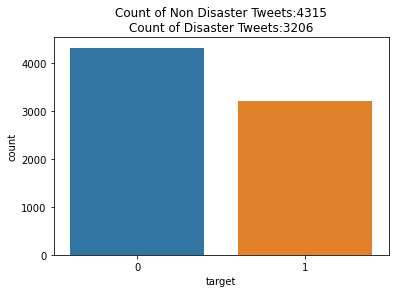

Cleaning Tweets ----> 

 Splitting Data into Train, Test and Validation Sample ----> 
Training Sample ---->  (6016, 7)
Testing Sample ---->  (752, 7)
Validation Sample ---->  (753, 7)

 Converting Data into Tensorflow Format ----> 

 Vectorizing Tweets ----> 
Vocabulary Length ---->  14646


In [4]:
classification_ob = DisasterTweetClassification()

# Train Models

## Baseline Models

### Model 1 ----> Multinomial Naive Bayes

In [5]:
classification_ob.train_naive_bayes()


 Training Multinomial Naive Bayes Algorithm ----> 
Naive Bayes Accuracy ---->  78.19148936170212


### Model 2 ----> Support Vector Machines

In [6]:
classification_ob.train_support_vector_machines()


 Training Support Vector Machine Algorithm ----> 
SVM Accuracy ---->  78.98936170212765


## Deep Learning Models

### Model 3 ----> LSTM Without Embedding


 Training LSTM without Embeddings ----> 
Epoch 1/5
188/188 [==============================] - 19s 47ms/step - loss: 0.5406 - accuracy: 0.7111 - val_loss: 0.4724 - val_accuracy: 0.7795
Epoch 2/5
188/188 [==============================] - 6s 30ms/step - loss: 0.2962 - accuracy: 0.8805 - val_loss: 0.5103 - val_accuracy: 0.7902
Epoch 3/5
188/188 [==============================] - 6s 30ms/step - loss: 0.1699 - accuracy: 0.9363 - val_loss: 0.6751 - val_accuracy: 0.7463
Epoch 4/5
188/188 [==============================] - 6s 30ms/step - loss: 0.1055 - accuracy: 0.9614 - val_loss: 0.9243 - val_accuracy: 0.7344
Epoch 5/5
24/24 [==============================] - 0s 9ms/step - loss: 1.2266 - accuracy: 0.7766
LSTM WITHOUT EMBEDDING TEST LOSS: 1.2266488075256348
LSTM WITHOUT EMBEDDING TEST ACCURACY: 0.7765957713127136


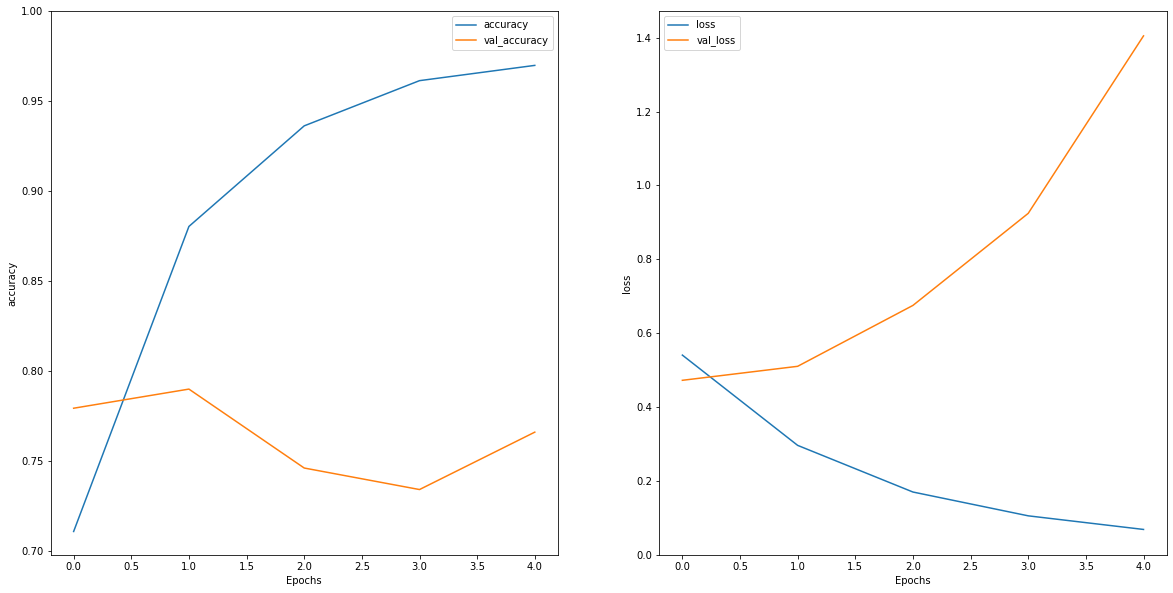

In [7]:
classification_ob.lstm_without_embedding()

### Model 4 ----> Bidirectional LSTM Without Embedding


 Training Bidirectional LSTM without Embeddings ----> 
Epoch 1/5
188/188 [==============================] - 32s 72ms/step - loss: 0.5339 - accuracy: 0.7192 - val_loss: 0.4700 - val_accuracy: 0.7782
Epoch 2/5
188/188 [==============================] - 7s 36ms/step - loss: 0.2810 - accuracy: 0.8881 - val_loss: 0.4948 - val_accuracy: 0.7835
Epoch 3/5
188/188 [==============================] - 7s 35ms/step - loss: 0.1592 - accuracy: 0.9407 - val_loss: 0.7049 - val_accuracy: 0.7663
Epoch 4/5
188/188 [==============================] - 7s 35ms/step - loss: 0.0973 - accuracy: 0.9628 - val_loss: 0.7787 - val_accuracy: 0.7503
Epoch 5/5
24/24 [==============================] - 0s 8ms/step - loss: 1.0319 - accuracy: 0.7819
BIDIRECTIONAL LSTM WITHOUT EMBEDDING TEST LOSS: 1.031888484954834
BIDIRECTIONAL LSTM WITHOUT EMBEDDING TEST ACCURACY: 0.7819148898124695


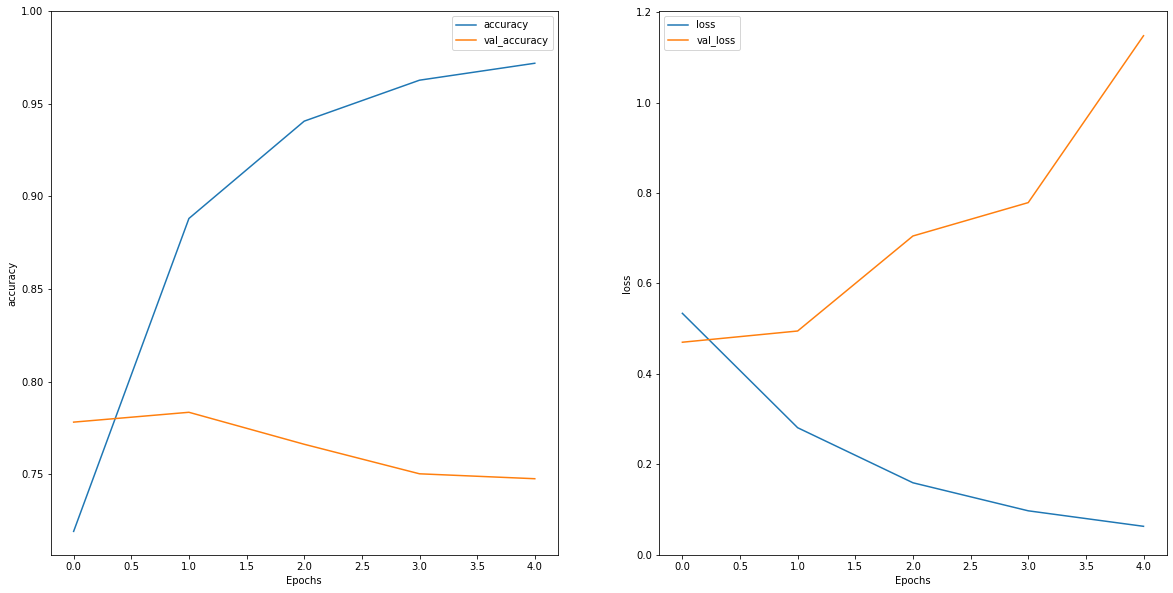

In [8]:
classification_ob.bilstm_without_embedding()

### Model 5 ----> LSTM With Attention


 Training LSTM with Attention ----> 
Epoch 1/5
188/188 [==============================] - 20s 50ms/step - loss: 0.5319 - accuracy: 0.7247 - val_loss: 0.4627 - val_accuracy: 0.7849
Epoch 2/5
188/188 [==============================] - 6s 33ms/step - loss: 0.2791 - accuracy: 0.8895 - val_loss: 0.5399 - val_accuracy: 0.7716
Epoch 3/5
188/188 [==============================] - 6s 33ms/step - loss: 0.1558 - accuracy: 0.9450 - val_loss: 0.6932 - val_accuracy: 0.7676
Epoch 4/5
188/188 [==============================] - 6s 33ms/step - loss: 0.0936 - accuracy: 0.9653 - val_loss: 0.9441 - val_accuracy: 0.7530
Epoch 5/5
24/24 [==============================] - 0s 10ms/step - loss: 0.8478 - accuracy: 0.7806
LSTM WITH ATTENTION TEST LOSS: 0.847840428352356
LSTM WITH ATTENTION TEST ACCURACY: 0.7805851101875305


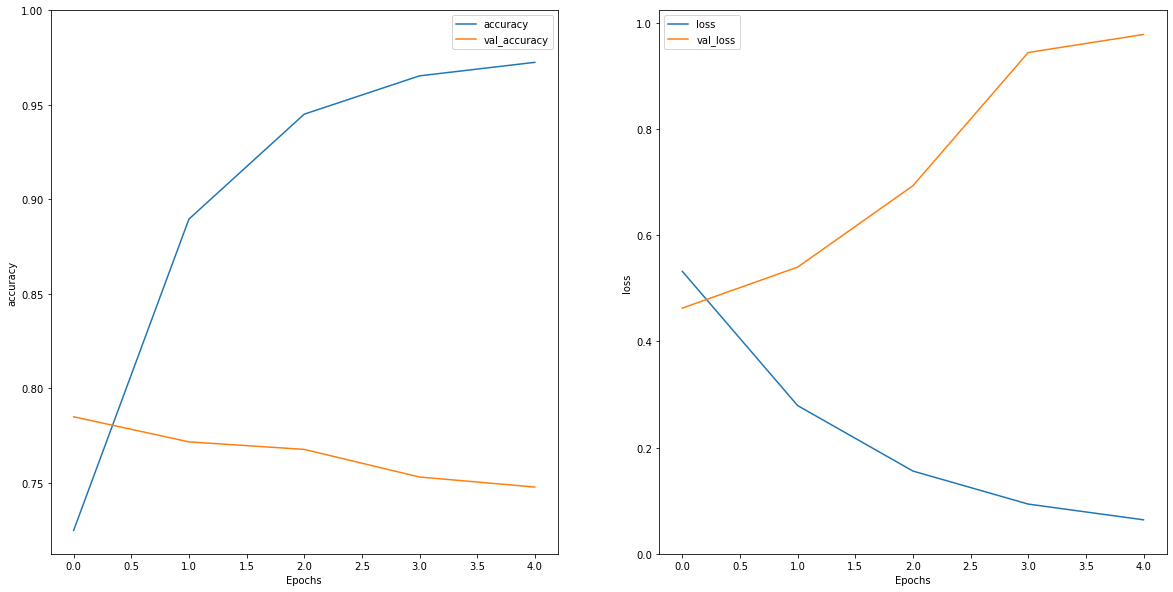

In [9]:
classification_ob.lstm_with_attention()

### Model 6 ----> LSTM with GLove


 Training LSTM with Glove ----> 


C:\Users\gupta\AppData\Local\Temp\ipykernel_3352\3445322398.py:244: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


Found 399973 Word Embeddings
Converted 9576 Words (3043 Misses)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/9
188/188 [==============================] - 60s 287ms/step - loss: 0.5126 - accuracy: 0.7427 - val_loss: 0.4585 - val_accuracy: 0.7955
Epoch 2/9
188/188 [==============================] - 53s 284ms/step - loss: 0.4598 - accuracy: 0.7904 - val_loss: 0.4483 - val_accuracy: 0.7995
Epoch 3/9
188/188 [==============================] - 53s 284ms/step - loss: 0.4439 - accuracy: 0.7919 - val_loss: 0.4474 - val_accuracy: 0.7968
Epoch 4/9
188/188 [==============================] - 54s 285ms/step - loss: 0.4297 - accuracy: 0.8060 - val_loss: 0.4467 - val_accuracy: 0.7928
Epoch 5/9
188/188 [==============================] - 53s 284ms/step - loss: 0.4262 - accuracy: 0.7980 - val_loss: 0.4407 - val_accuracy: 0.7809
Epoch 6/9
188/188 [==============================] - 51s 270ms/step

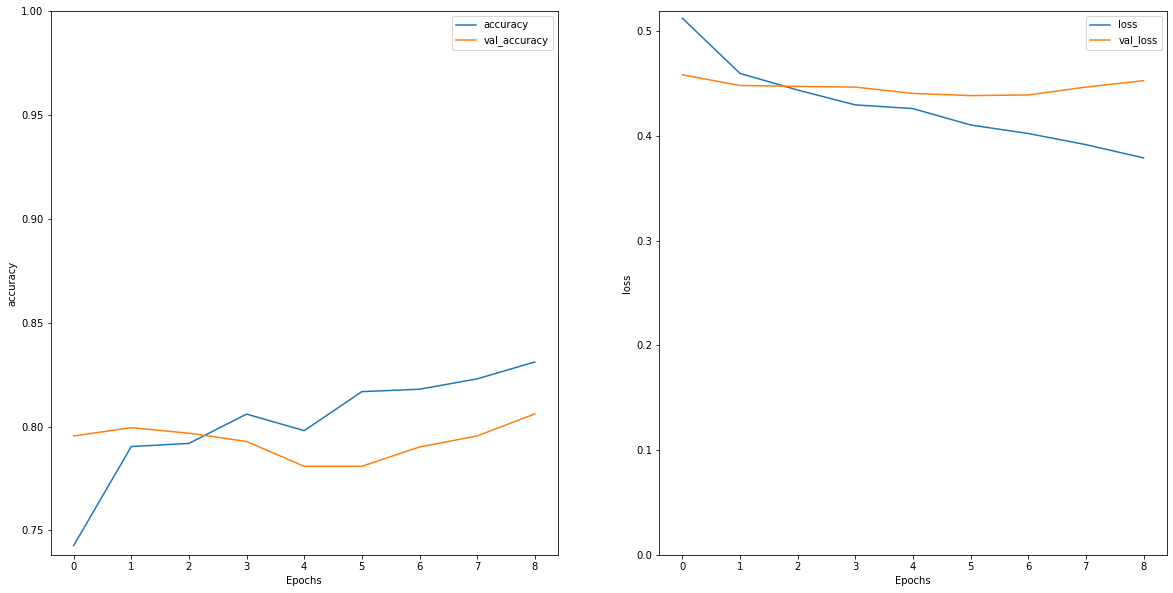

In [10]:
classification_ob.lstm_with_glove()